# ARIMA FORECAST

In [2]:
# handling data
import pandas as pd
import numpy as np
import datetime
import time

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
#import catboost
#from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx


print("Setup Complete")

Setup Complete


In [3]:
pwd

'/Users/aidanlew'

In [4]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [65]:
def parser(x):
    return pd.to_datetime(x, format='%Y-%m-%d)

In [83]:
ten_golden_df = pd.read_csv('GS_yahoo.csv', 
                            header=0, 
                            parse_dates=[0], 
                            date_parser=parser,
                           usecols=['Date', 'Close'])

ten_golden_df.head(10)

,Date,Close
0,2013-01-02,131.660004
1,2013-01-03,130.940002
2,2013-01-04,134.509995
3,2013-01-07,134.259995
4,2013-01-08,133.050003
5,2013-01-09,134.320007
6,2013-01-10,137.369995
7,2013-01-11,137.130005
8,2013-01-14,136.130005
9,2013-01-15,135.589996


In [76]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(7).mean()
    dataset['ma21'] = dataset['Close'].rolling(21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    
    return dataset

ten_TI_df = get_technical_indicators(ten_golden_df)
ten_TI_df.head()

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2013-01-02,131.660004,NaN,NaN,131.660004,131.660004,0.000000,NaN,NaN,NaN,131.660004,130.660004
1,2013-01-03,130.940002,NaN,NaN,131.286157,131.270003,-0.016154,NaN,NaN,NaN,131.120002,129.940002
2,2013-01-04,134.509995,NaN,NaN,132.444451,132.534573,0.090122,NaN,NaN,NaN,133.466920,133.509995
3,2013-01-07,134.259995,NaN,NaN,132.951997,133.079221,0.127224,NaN,NaN,NaN,134.002246,133.259995
4,2013-01-08,133.050003,NaN,NaN,132.974725,133.071283,0.096557,NaN,NaN,NaN,133.364794,132.050003


Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


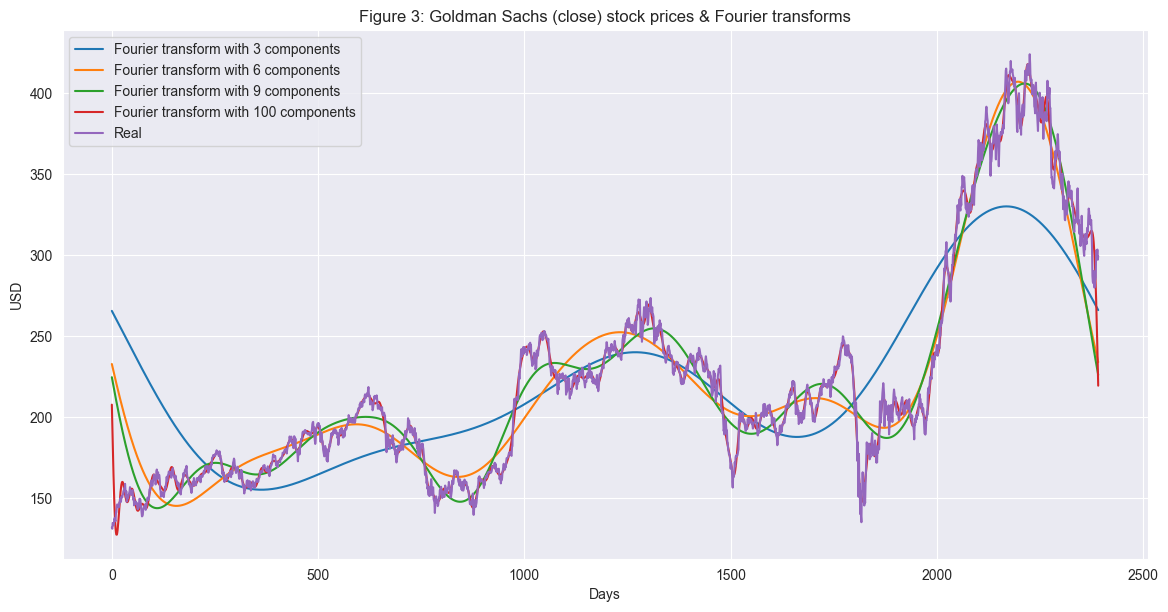

In [77]:
ten_data_FT = ten_TI_df[['Date', 'Close']]

close_fft = np.fft.fft(np.asarray(ten_data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))


plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(ten_data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [78]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = ten_golden_df['Close']
model = ARIMA(ten_golden_df['Close'], 
              order=(5, 1, 0), 
              dates=ten_golden_df['Date'], 
              freq='B'
             )
model_fit = model.fit()
print(model_fit.summary())

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


ValueError: The given frequency argument could not be matched to the given index.

In [79]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# X is a series of the prices of stock
series = ten_golden_df['Close']
X = series.values

size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

#for every day in test, predict an "observation" for that day and add it to the lists
#what I've tried: t in range(len(X))

steps = list(range(1,301))

for t in range(len(X)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X[t]
    history.append(obs)

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(X, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [ ]:
ten_TI_df.tail()

In [80]:
model = ARIMA(ten_df['Close'], order=(5,1,0),freq='B')
model_fit = model.fit()
forecast_trial = model_fit.get_prediction(start = 2400, end = 2500, freq='B', type='levels')
#mean_forecast = forecast_trial.predicted_mean


NameError: name 'ten_df' is not defined

In [ ]:
forecast_trial

In [ ]:
confidence_intervals = forecast_trial.conf_int()
confidence_intervals.head(10)

In [82]:
lower_limits = confidence_intervals['lower Close']
upper_limits = confidence_intervals['upper Close']

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

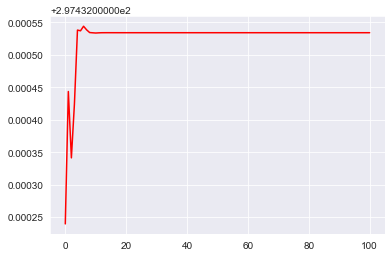

In [86]:
#to get CI in there, need to do the 'dates' in the example to sync the index

plt.figure()

# Plot prediction
plt.plot(
    mean.values,
    color='red',
    label='forecast')

# Shade uncertainty area
plt.fill_between(mean.index, lower_limits, upper_limits, color='pink')
plt.show()


###seems to go for 30 steps, but perhaps needs an update every time it steps###

boris steaight up took this code lol
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=time%20series%20forecasts.-,ARIMA%20is%20an%20acronym%20that%20stands%20for%20AutoRegressive%20Integrated%20Moving,AR%3A%20Autoregression.


https://www.irjet.net/archives/V8/i8/IRJET-V8I829.pdf

ARIMA:
https://www.youtube.com/watch?v=JMT1eGJ9c2M
LSTM:
https://www.youtube.com/watch?v=dKBKNOn3gCE







# Following along with an example 
should be easy, right?

In [109]:
df=ten_golden_df
df.tail()

,Date,Close
2387,2022-06-27,300.779999
2388,2022-06-28,299.489990
2389,2022-06-29,303.279999
2390,2022-06-30,297.019989
2391,2022-07-01,299.230011


In [85]:
df.describe()

,Close
count,2392.000000
mean,221.015928
std,66.369019
min,130.940002
25%,171.884998
50%,203.020004
75%,239.590000
max,423.850006


In [86]:
n = int(len(df)*0.8)
train = df.Close[:n]
test = df.Close[n:]

In [87]:
print(len(train))
print(len(test))

1913
479


In [128]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

model = ARIMA(train, order=(5,1,0))
result = model.fit()

In [129]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1913
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4979.137
Date:                Tue, 02 Aug 2022   AIC                           9970.274
Time:                        13:35:13   BIC                          10003.593
Sample:                             0   HQIC                          9982.538
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0725      0.011     -6.418      0.000      -0.095      -0.050
ar.L2          0.0636      0.013      4.922      0.000       0.038       0.089
ar.L3         -0.0079      0.014     -0.573      0.566      -0.035       0.019
ar.L4         -0.0442      0.014     -3.243      0.001      -0.071      -0.017
ar.L5         -0.0107      0.013     -0.798      0.425      -0.037       0.016
sigma2        10.8491      0.170     63.886      0.000      10.516      11.182
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4519.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.74   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
step = 300

#this is where the funkiness occurs
fc = result.get_forecast(step)

In [132]:
fc = fc.predicted_mean

In [107]:
pred_ci = fc.conf_int()

AttributeError: 'Series' object has no attribute 'conf_int'

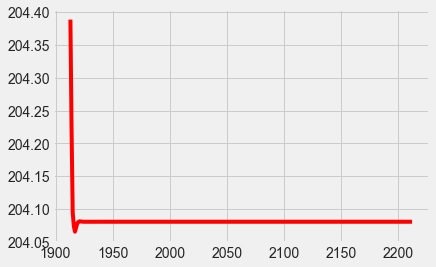

In [133]:
plt.figure()

#Plot prediction
plt.plot(
    fc,
    color='red',
    label='forecast')

In [24]:
ax = y.plot(label='observed', figsize=(20, 15))
fc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')

plt.legend()
plt.show()




NameError: name 'y' is not defined

In [136]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#data = sm.datasets.co2.load_pandas()
#y = data.data

y=df
#y = pd.to_datetime(df, format='%Y%m%d')

# The 'MS' string groups the data in buckets by start of the month
#y = y['Close'].resample("B")
y.head(3)

,Date,Close
0,2013-01-02,131.660004
1,2013-01-03,130.940002
2,2013-01-04,134.509995


In [122]:

# The term bfill means that we use the value before filling in missing values
#y = y.fillna(y.bfill())

#print(y)

#y.plot(y.Close, figsize=(15, 6))
#plt.show()

In [123]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [138]:
np.asarray(y)

array([[Timestamp('2013-01-02 00:00:00'), 131.660004],
       [Timestamp('2013-01-03 00:00:00'), 130.940002],
       [Timestamp('2013-01-04 00:00:00'), 134.509995],
       ...,
       [Timestamp('2022-06-29 00:00:00'), 303.279999],
       [Timestamp('2022-06-30 00:00:00'), 297.019989],
       [Timestamp('2022-07-01 00:00:00'), 299.230011]], dtype=object)

In [137]:
mod = ARIMA(y, order=(5,1,0))
results = mod.fit()


print(results.summary().tables[1])

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [127]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()
pred = results.get_prediction(start=pd.to_datetime('2013-01-02'), dynamic=False)
pred_ci = pred.conf_int()


NameError: name 'results' is not defined

In [ ]:
ax = y['2016-10-30 04:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Delays')
plt.legend()

plt.show()

In [ ]:








y_forecasted = pred.predicted_mean
y_truth = y['2016-11-20 00:00:00':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

pred_dynamic = results.get_prediction(start=pd.to_datetime('2016-11-20 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['2016-10-30 04:00:00':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-11-20 00:00:00'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Delays')

plt.legend()
plt.show()

y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2016-11-20 00:00:00':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=32)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
print(pred_ci.iloc[:, 1])

ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Delays')

plt.legend()
plt.show()

# Ok I'm getting pissed at the ARIMA 
so I'm pivoting to also capture more complexity in the market.

New strat: Give Catboost a bunch of indicators: Technnical indicators, forrier transforms, BERT, ARIMA, (GAN maybe) and use it to predict future points if possible

https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

pt 1:https://medium.com/artefact-engineering-and-data-science/time-series-forecasting-how-did-we-put-our-first-sales-forecasting-solution-for-croissants-into-93f9ed45bb49

pt 2:https://medium.com/artefact-engineering-and-data-science/how-did-we-put-our-sales-forecasting-solution-for-croissants-into-production-eba5eb73d0bf

https://www.tandfonline.com/doi/pdf/10.1080/01605682.2020.1843976

https://arxiv.org/pdf/2001.02121.pdf

https://www.youtube.com/watch?v=_1dCAigafzo



Might need to go to XGBoost
https://www.youtube.com/watch?v=4rikgkt4IcU


In [ ]:
- try yahoo finance
- try CSV vs. excel
- try to get different ARIMA parameters